# Project: Advanced Lane Finding

This project builds a pipeline to identify lane boundaries from a car's front camera.

##### Importing Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
import numpy as np
import cv2
import pickle
import glob

%matplotlib inline

### 1. Carmera Calibration

#### 1.1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

Extract object and image points for camera calibration.

At first, we prepare object points, that are x, y and z points in the real world of the chessboard corners. I assume that they're all on the z plane. 

Now we loop through each of the images converting them to greyscale. 

Then we use cv2.findChessboardCorners to find the image coordinates of the object points and finally append both to a copy of them. 

Finally, we use cv2.calibrateCamera to get the camera matrix and distortion coefficients.

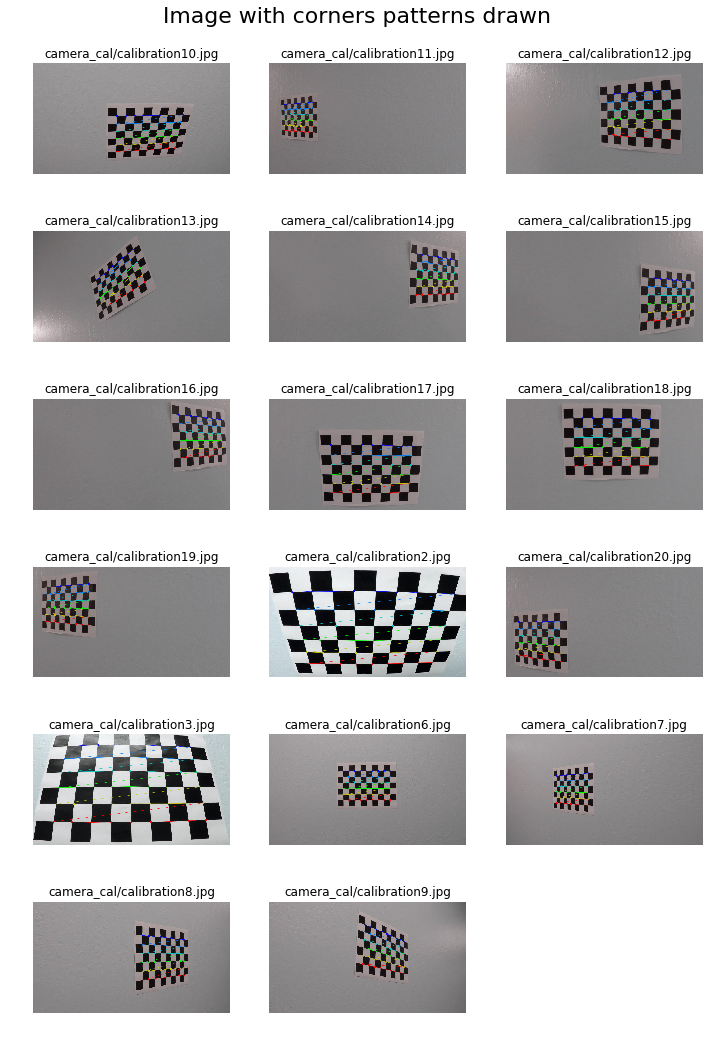

Corners found on 17 out of 20
85.0 % of images calibrated


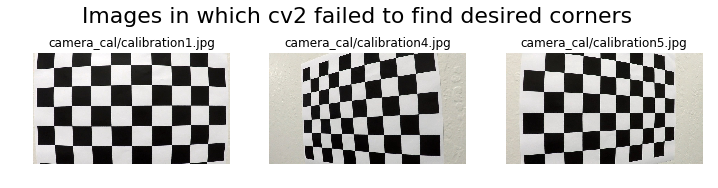

In [2]:
# Number of corners
x_cor = 9 
y_cor = 6

objp = np.zeros((y_cor*x_cor,3), np.float32)
objp[:,:2] = np.mgrid[0:x_cor, 0:y_cor].T.reshape(-1,2)

# Object and image points from all the images.
objpoints = [] # 3d points
imgpoints = [] # 2d points

# Path to calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Search for chessboard corners
corners_not_found = []
plt.figure(figsize=(12, 18))
plt.figtext(0.5,0.9,'Image with corners patterns drawn', fontsize=22, ha='center')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Conver to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (x_cor,y_cor), None) # Find the chessboard corners
    # If found, add object and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (x_cor,y_cor), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
    else:
        corners_not_found.append(fname)
plt.show()

print ('Corners found on', str(len(imgpoints)), 'out of', str(len(images)))
print(str(len(imgpoints)*100.0/len(images)),'% of images calibrated')

# Draw boards
plt.figure(figsize=(12, 4))
plt.figtext(.5,.8,'Images in which cv2 failed to find desired corners', fontsize=22, ha='center')
for i, p in enumerate(corners_not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p))
    plt.title(p)
    plt.axis('off')
plt.show()


The last 3 images failed because, as we can see, the chessboard is cropped in some part. So our solution can't find the required number of corners.

## 2. Pipeline

#### 2.1. Provide an example of a distortion-corrected image.

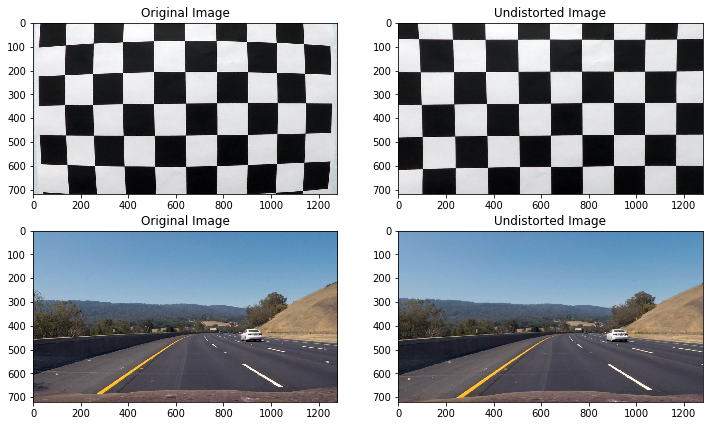

In [3]:
# Undistortion process
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Camera calibration given object and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undistort(img))
plt.title("Undistorted Image")

img = cv2.imread('test_images/test3.jpg')
undist = undistort(img)

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")
plt.savefig("output_images/undist_img.jpg")

#### 2.2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.


**Thresholded binary image**

We'll be performing Histogram normalization, binary Sobel transformation(magnitude and direction), red color channel and saturation channel. 

An adaptive threshold was applied on a red channel image for white line finding and on a linear combination of the red and saturation channels for the yellow line.

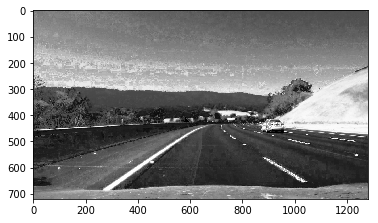

In [4]:
# Histogram normalization
def eq_Hist(img):
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img

# Sobel
def sobel_img(img, thresh_min = 25, thresh_max = 255, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobelx = np.uint16(255*sobelx/np.max(sobelx))
    scaled_sobely = np.uint16(255*sobely/np.max(sobely))
    sobel_sum = scaled_sobelx+0.2*scaled_sobely
    scaled_sobel_sum = np.uint8(255*sobel_sum/np.max(sobel_sum))
    sum_binary = np.zeros_like(scaled_sobel_sum)
    sum_binary[(scaled_sobel_sum >= thresh_min) & (scaled_sobel_sum <= thresh_max)] = 1
    return sum_binary

# Solbel magnitude
def sobel_mag_img(img, thresh_min = 25, thresh_max = 255, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    gradmag_binary = np.zeros_like(scaled_gradmag)
    gradmag_binary[(scaled_gradmag >= thresh_min) & (scaled_gradmag <= thresh_max)] = 1
    return gradmag_binary

# Sobel direction
def sobel_dir_img(img, thresh_min = 0.0, thresh_max = 1.5, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    graddir = np.arctan2(sobely, sobelx)
    graddir_binary =  np.zeros_like(graddir)
    graddir_binary[(graddir >= thresh_min) & (graddir <= thresh_max)] = 1
    return  graddir_binary

# Binary red channel threshold
def red_thres(img, thresh_min = 25, thresh_max = 255):
    red = img[:,:,2]
    red_binary = np.zeros_like(red)
    red_binary[(red >= thresh_min) & (red <= thresh_max)]  = 1
    return red_binary

# Binary saturation channel threshold
def s_thres(img, thresh_min = 25, thresh_max = 255):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh_min) & (s_channel <= thresh_max)] = 1
    return s_binary

# Return saturation channel
def s_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,2]

# Visualize an example
imagefilename = 'test_images/test3.jpg'
img = cv2.imread(imagefilename)
img = eq_Hist(img)
img_proc = img[:,:,2]+0.5*s_hls(img)
img_proc = np.uint8(255*img_proc/np.max(img_proc))
plt.imshow(img_proc, cmap='gray')

Now, we convert the image to three color spaces, gray, hls and hsv. We'll use these converted images to extract features and combine them later to get the lane lines.

We use a combination of the following channels:
- gray: absolute sobel x direction threshold
- gray: direction threshold
- rgb r: threshold - combined with the one below for yellow lines
- rgb g: threshold
- hls s: threshold
- hls l: threshold
- hsv v: absolute sobel x direction threshold
- hls s: absolute sobel x direction threshold

Some of these are quite noisy under some circumstances. Like shadows from trees or lighter patches of road, but are combined in such a way that the combined version is more stable.

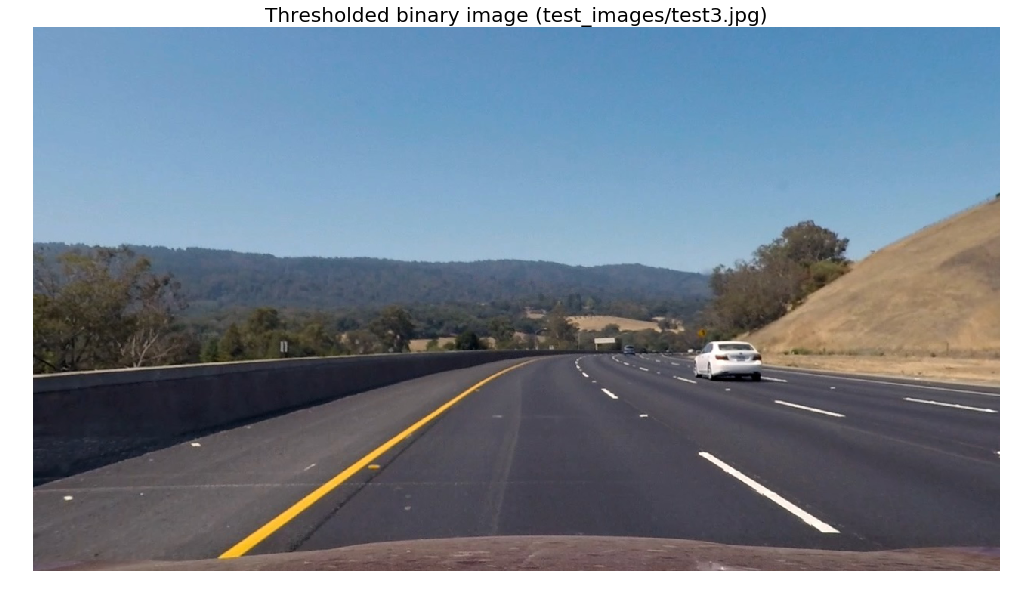

In [5]:
def abs_sobel_thresh(image, orient='x', kernel_size=3, thresh=(0,255)):
    ori = [1, 0] if orient == 'x' else [0, 1]
    sobel = cv2.Sobel(image, cv2.CV_64F, ori[0], ori[1], ksize=kernel_size)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, kernel_size=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] =1
    return mag_binary

def dir_threshold(image, kernel_size=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] =1
    return dir_binary

def thresh(image, thresh=(0, 255)):
    thresh_binary = np.zeros_like(image)
    thresh_binary[(image >= thresh[0]) & (image <= thresh[1])] = 1
    return thresh_binary

def convert_image(image):
    # gray sobel_x & direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    gray_x_binary = abs_sobel_thresh(gray, thresh=(10, 200))
    gray_dir_binary = dir_threshold(gray, thresh=(.5, 1.6))
    gray_combined = (gray_x_binary == 1) & (gray_dir_binary == 1)
    
    # yellow lines
    rgb_r = image[:,:,0]
    rgb_g = image[:,:,1]
    rgb_r_binary = thresh(rgb_r, (150, 255))
    rgb_g_binary = thresh(rgb_g, (150, 255))
    rgb_combined = (rgb_r_binary == 1) & (rgb_g_binary == 1)
    
    # Both of these are quite noisy, but are combined below in selector in a way that makes them more stable
    hls_l = hls[:,:,1]
    hls_s = hls[:,:,2]
    hls_l_binary = thresh(hls_l, (120, 255))
    hls_s_binary = thresh(hls_s, (100, 255))
    
    # Adds a little bit of information in highly irregularly shadowed areas like under trees
    hsv_v = hsv[:,:,2]
    hsv_v_sobel_x = abs_sobel_thresh(hsv_v, thresh=(30, 100))
    hls_s_sobel_x = abs_sobel_thresh(hls_s, thresh=(30, 100))
    
    selector = ((rgb_combined == 1) & (hls_l_binary == 1)) & ((hls_s_binary == 1) | (gray_combined == 1)) |\
        (((hsv_v_sobel_x == 1) | (hls_s_sobel_x == 1)))
    
    combined = np.zeros_like(rgb_r)
    combined[selector] = 1
    
    return combined

def image_plotter(image, title='', cmap=None, show_axis=False):
    f, ax = plt.subplots(1, 1, figsize=(20,10))
    ax.set_title(title, fontsize=20)
    ax.imshow(image, cmap=cmap)
    if not show_axis:
        ax.set_axis_off()
    plt.show()

imagefilename = 'test_images/test3.jpg'
img = mpimg.imread(imagefilename)
undist = undistort(img)
image_plotter(undist, title='Thresholded binary image ({})'.format(imagefilename), cmap='gray')

The binary and channel versions of the image above looks as follows 

In [6]:
def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    
    return  binary,channels

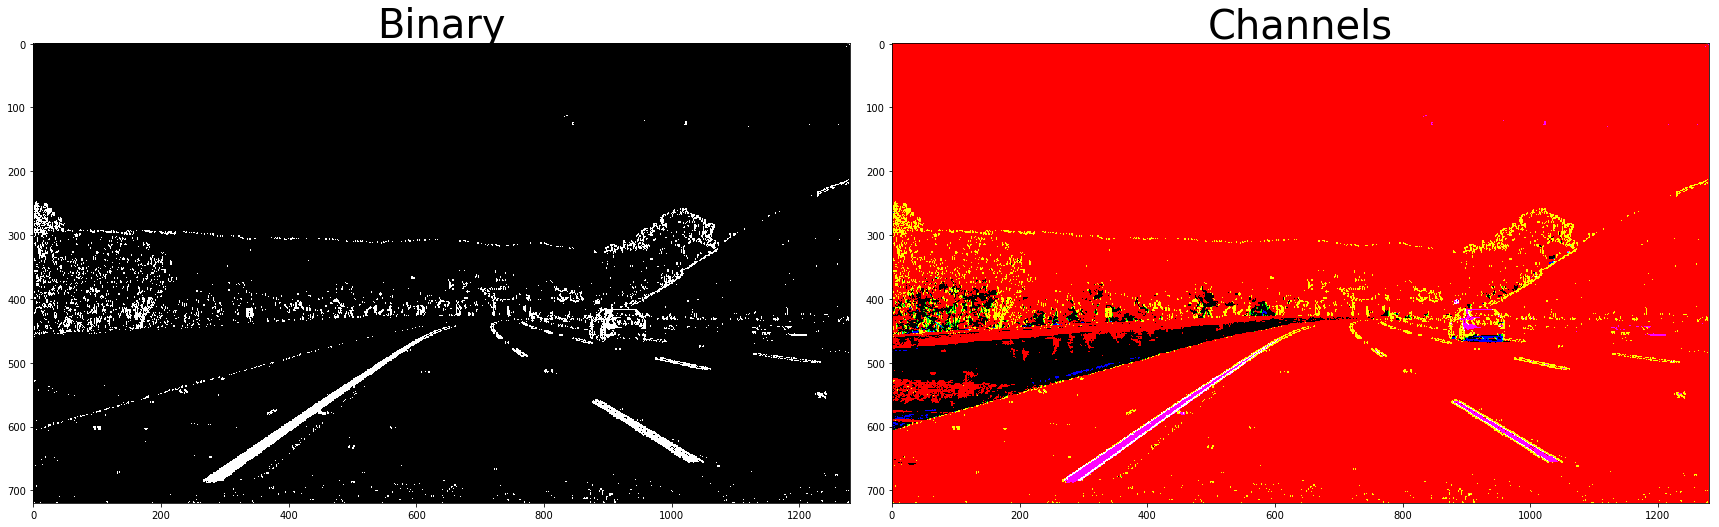

In [7]:
img = plt.imread('test_images/test3.jpg')

shape = img.shape
binary,channels = binarize(img)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary)
ax1.set_title('Binary', fontsize=40)

ax2.imshow(channels)
ax2.set_title('Channels', fontsize=40)

#### 2.3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

We'll be getting an image with straight lane lines, to draw a few points to define an isoceles trapezoid where the left and right lines overlay the lane lines. The image I used was test_images/test3.jpg. 

The lane lines are supposed to be straight where I created dst points that form a rectangle. I added an offset from the left and right side that leaves room for curving lines. Then I get the transformation using these points with cv2.getPerspectiveTransform, as well as the inverse which will be used for transforming back from top-down view to our normal view.

The warp function uses the transformation matrix to transform the image from our normal view to the top-down view.

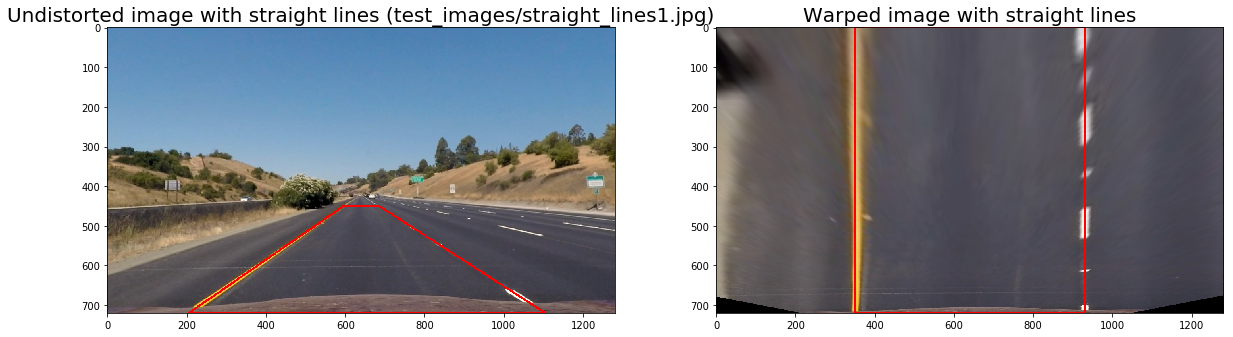

In [8]:
def warp(image):
     return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

def draw_lines(image, points, color=(255, 0, 0)):
    return cv2.polylines(np.copy(image), np.int32([points]), True, color, 3)


offset = 350
img_size = undist.shape[0:2][::-1]

src = np.array([[596,450],[685, 450],[1105,720], [205, 720]], np.int32)
src = src.reshape((-1,1,2))

dst = np.array([[0+offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [0+offset, img_size[1]]])
dst = dst.reshape((-1,1,2))

M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))

imagefilename_straight = 'test_images/straight_lines1.jpg'
undist_straight = undistort(mpimg.imread(imagefilename_straight))
warped_straight = warp(undist_straight)
undist_straight_lines = draw_lines(undist_straight, src)
warped_straight_lines = draw_lines(warped_straight, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with straight lines ({})'.format(imagefilename_straight), fontsize=20)
ax1.imshow(undist_straight_lines)
ax2.set_title('Warped image with straight lines', fontsize=20)
ax2.imshow(warped_straight_lines)
plt.show()

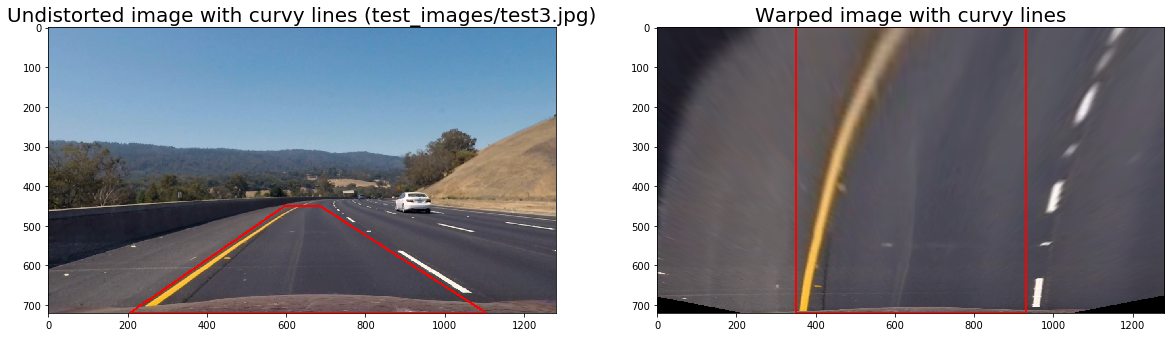

In [9]:
warped = warp(undist)
undist_lines = draw_lines(undist, src)
warped_lines = draw_lines(warped, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with curvy lines ({})'.format(imagefilename), fontsize=20)
ax1.imshow(undist_lines)
ax2.set_title('Warped image with curvy lines', fontsize=20)
ax2.imshow(warped_lines)
plt.show()

#### 2.4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

- First step is to get a histogram of the lower half binary warped image. Which is used to identify where to start looking for lane lines. 

- Now we look for parts of the lane lines starting from the bottom. 

- Then, we use np.polyfit to fit a 2nd order polynomial to the points we identified as being part of lane lines. 

- And finally, we collect the data created in this method and return it.

In [10]:
def fit_lanes(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Define empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Rectangles, returned if we want them for visalization
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
       
        # Collect the windows
        rectangles.append(((win_xleft_low,win_y_low), (win_xleft_high,win_y_high)))
        rectangles.append(((win_xright_low,win_y_low), (win_xright_high,win_y_high)))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, rectangles

In [11]:
def visualize_fit_lanes(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    output_image = np.dstack((binary_warped, binary_warped, binary_warped))*255
    for rectangle in rectangles:
        cv2.rectangle(output_image, rectangle[0], rectangle[1], (0,255,0), 2)
    
    output_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    output_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    f, ax = plt.subplots(1, 1, figsize=(20,10))
    ax.imshow(output_image)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

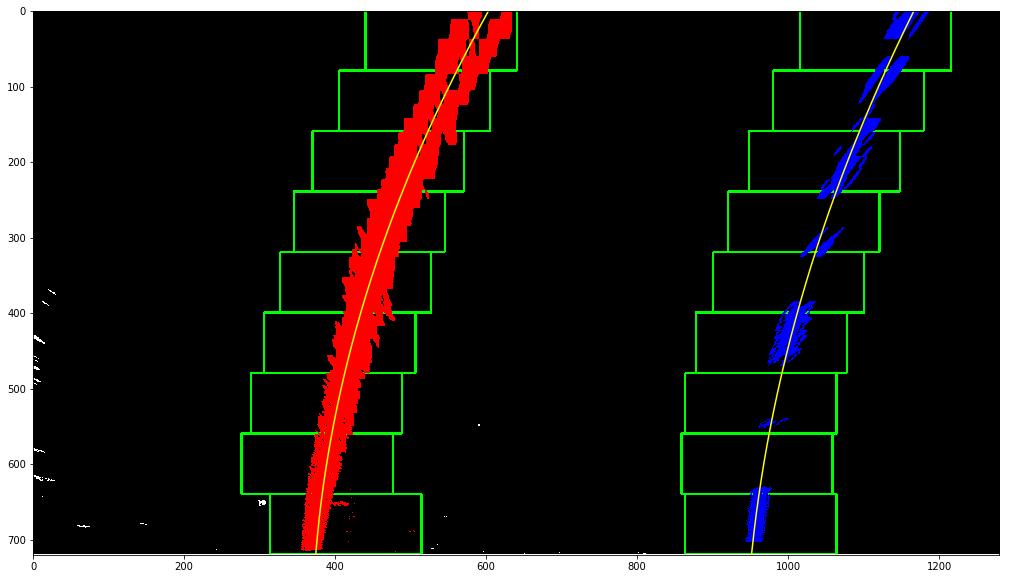

In [12]:
binary_warped = warp(convert_image(undist))
left_fit, right_fit, left_fitx, right_fitx, left_lane_inds,right_lane_inds, rectangles = fit_lanes(binary_warped)

visualize_fit_lanes(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles)

#### 2.5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

For curve radius I first get new coefficients for curvature in the real world, not pixel space. Then calculate the radius with the new polynomial.

In [13]:
def curve_radius(image, fitx):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    radius = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return radius

curve_left = curve_radius(binary_warped, left_fitx)
curve_right = curve_radius(binary_warped, right_fitx)
print("Left curve radius: {:.2f}, right curve radius: {:.2f}".format(curve_left, curve_right))

Left curve radius: 498.34, right curve radius: 601.27


And to get the distance from the center we look at the lowest row of the image and find the x coordinates of the lanes to get the centerpoint of both the lanes and the screen. 

We take the difference and multiply it with the meters per pixel ratio to get it in meters. If the number is negative the car is to the left of the center. If it's greater than 0 it's to the right of the center.

In [14]:
def center_distance(image, left_fit, right_fit):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(ploty)
    image_center = image.shape[1]/2
    left_lane = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lanes_center = (left_lane + right_lane)/2
    
    # Lanes are rought 600 pixels apart at the lower end of the image (meters per pixel in x dimension)
    xm_per_pix = 3.7/600
    meters_center = (image_center-lanes_center)*xm_per_pix
    return meters_center

center_distance(binary_warped, left_fit, right_fit)

-0.14223728031193111

If the camera it's considered to be located at the center of the car, then we may assume that the car is about 0.15 meters to the left of the center of the lane in this image.

#### 2.6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

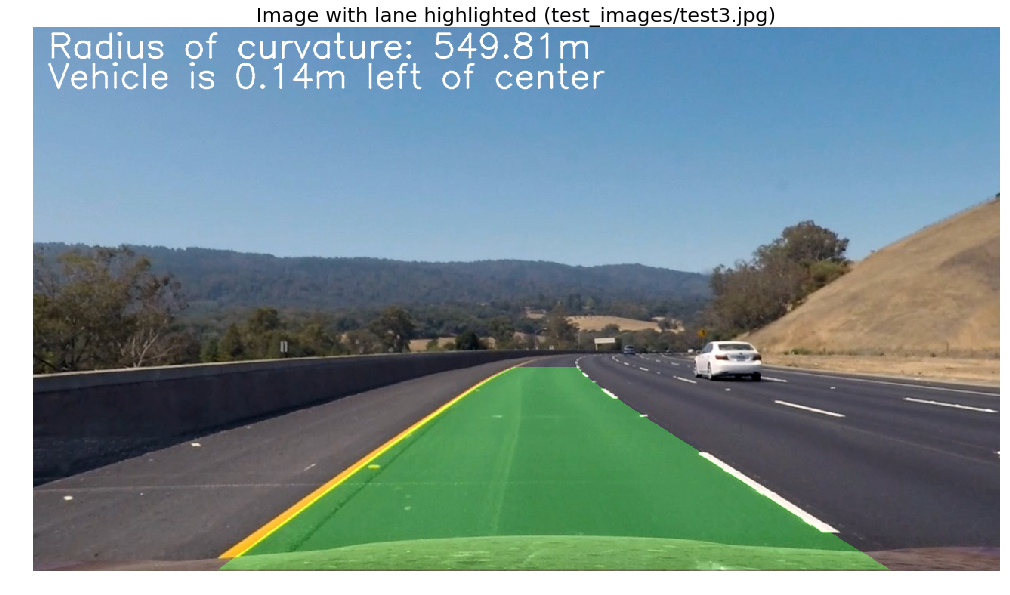

In [15]:
def draw_lane(undist, left_fit, right_fit, text=True):
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img = cv2.imread('test_images/test3.jpg')
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    if text:
        curve_left = curve_radius(undist, left_fitx)
        curve_right = curve_radius(undist, right_fitx)
        curve_avg = (curve_left + curve_right)/2
        off_center = center_distance(img, left_fit, right_fit)
        
        radius_text = "Radius of curvature: {:.2f}m".format(curve_avg)
        center_dir = off_center < 0 and "left" or "right"
        center_text = "Vehicle is {:.2f}m {} of center".format(abs(off_center), center_dir)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_color = (255., 255., 255.)
        
        cv2.putText(result, radius_text, (20, 40), font, 1.5, font_color, 2, cv2.LINE_AA)
        cv2.putText(result, center_text, (20, 80), font, 1.5, font_color, 2, cv2.LINE_AA)
    return result

image_lane = draw_lane(undist, left_fit, right_fit)
image_plotter(image_lane, title='Image with lane highlighted ({})'.format(imagefilename))

## 3. Pipeline (video)

#### 3.1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Final video output is saved at [Video Output](./video_output.mp4)

In [ ]:
class Line():
    def __init__(self, num_average=2):
        self.fit = []
        self.best_fit = []
        self.num_average = num_average
    def add_fit(self, fit, sane=True):
        if sane or len(self.fit) < 1:
            self.fit.append(fit)
        if len(self.fit) > self.num_average:
            self.fit.pop(0)
        self.best_fit = np.mean(self.fit, axis=0)
        
def sanity_check(left_fitx, right_fitx):
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    distance_vector = [abs(rx-lx) for lx, rx in zip(left_fitx, right_fitx)]
    max_distance = max(distance_vector)
    if max_distance > 800:
        return False
    return True

def pipeline(image):
    left_line = Line()
    right_line = Line()
    undist = undistort(image)
    binary = convert_image(undist)
    warped = warp(binary)
    left_fit, right_fit, left_fitx, right_fitx, _, _, _ = fit_lanes(warped)
    sane = sanity_check(left_fitx, right_fitx)
    left_line.add_fit(left_fit, sane)
    right_line.add_fit(right_fit, sane)
    image_lane = draw_lane(undist, left_line.best_fit, right_line.best_fit)
    return image_lane

from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_filename = 'video_challenge_output.mp4'
input_filename = 'challenge_video.mp4'

clip1 = VideoFileClip(input_filename)
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(output_filename, audio=False)

## 4. Discussion

#### 4.1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

When taking the harder_challenge_video.mp4 video I've found a few issues realted to:
- the similarity of colors from the road and lane lines, 
- shadows over the lines. 

Reprojecting into birds-eye view and fitting lane lines by polynomial is promising method which may find not only straight lane lines but also curved ones. But it is not robust enough to deal with complex environment with tree shadows, road defects, brightness/contrast issues. It will be effective on environments where lane lines are bright, contrast, not occluded or overlapped.

Changing the thresholding might be a solution. The video filtering algorithm can be improved in order to make it more robust on the harder_challenge_video.mp4 and other real-world videos.

Also if you can see one line clearly you know the rough estimate for the other, right now my approach identifies one line separately, having information about the other line as well, and assigning a probability to how certain you are this line is correct might help.